In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from src import read_dicom, Detector, Siddon
from src.metrics import xcorr2

device = torch.device("cuda:0")

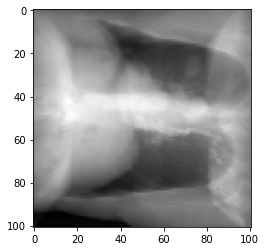

In [2]:
# Read in the volume
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

def make_drr(source, center, height=101, delx=10.):
    """Detector parameters -> DRR"""
    detector = Detector(
        source=source,
        center=center,
        height=height,
        width=height,
        delx=delx,
        dely=delx,
        device=device
    )
    source = detector.source
    rays = detector.make_xrays()
    drr = siddon.raytrace(source, rays)
    return drr

def plot(drr):
    plt.imshow(drr.detach().cpu(), cmap="gray")
    plt.show()

# Get the ground truth DRR
def corr(drr, est):
    x = xcorr2()
    return x(drr.expand(1, 1, -1, -1), est.expand(1, 1, -1, -1)).item()

def norm(drr, est):
    return torch.norm(drr - est).item()

drr = make_drr([-100., 160.1, 161.], [500., 180., 160.])
plot(drr)

In [3]:
def get_normxcorr2(x, y):
    est = make_drr([x, y, 161.], [500., 180., 160.])
    return corr(drr, est)

In [4]:
def get_norm2(x, y):
    est = make_drr([x, y, 161.], [500., 180., 160.])
    return norm(drr, est)

100%|████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.29it/s]
/home/vivekg/vivekg/miniconda3/envs/DiffDRR/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.5, 'Y-disp (cm)')

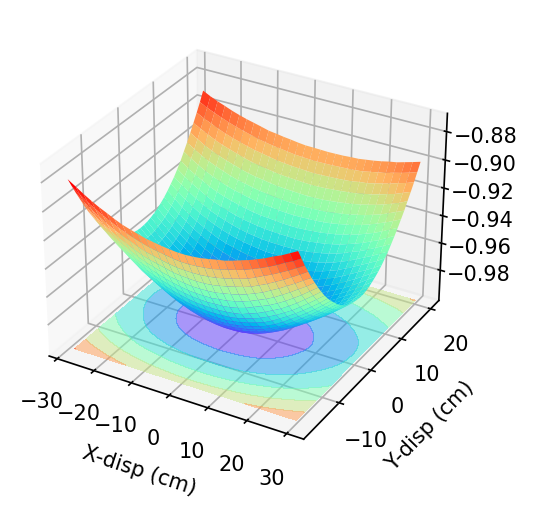

In [5]:
xs = torch.arange(-130., -70., step=2)
ys = torch.arange(140., 179.)

corrs = []
for x in tqdm(xs):
    for y in ys:
        xcorr = get_normxcorr2(x.item(),y.item())
        corrs.append(-xcorr)
        
zs = torch.tensor(corrs).reshape(len(xs), len(ys))
xs, ys = torch.meshgrid(
    xs - (-100.), 
    ys - 160.1
)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

x,y,z = -xs, -ys, zs

contour = ax.contourf(x,y,z,zdir='z', offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
surf = ax.plot_surface(x,y,z, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))

ax.set_xlabel('X-disp (cm)')
ax.set_ylabel('Y-disp (cm)')
# ax.set_zlabel('Negative NCC')

100%|████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.29it/s]


Text(0.5, 0.5, 'Y-disp (cm)')

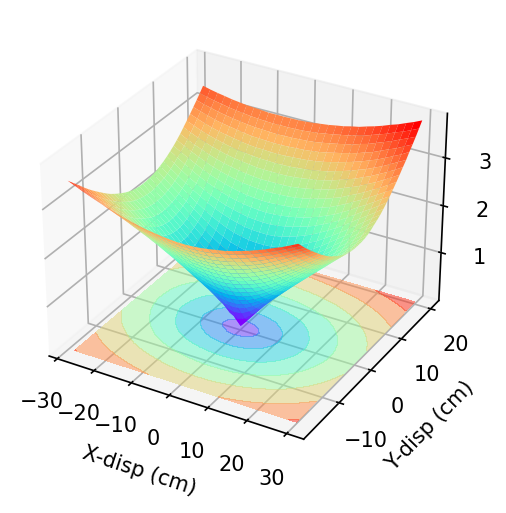

In [6]:
xs = torch.arange(-130., -70., step=2)
ys = torch.arange(140., 179.)

corrs = []
for x in tqdm(xs):
    for y in ys:
        xcorr = get_norm2(x.item(),y.item())
        corrs.append(xcorr)
        
zs = torch.tensor(corrs).reshape(len(xs), len(ys))
xs, ys = torch.meshgrid(
    xs - (-100.), 
    ys - 160.1
)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

x,y,z = -xs, -ys, zs

contour = ax.contourf(x,y,z,zdir='z', offset=-1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
surf = ax.plot_surface(x,y,z, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))

ax.set_xlabel('X-disp (cm)')
ax.set_ylabel('Y-disp (cm)')
# ax.set_zlabel('Negative NCC')